# 二维定常达西问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_darcy2D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_darcy2D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/physics_driven/darcy2D.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

达西方程（Darcy equation）是一个描述了流体在多孔介质中低速流动时渗流规律的二阶椭圆型偏微分方程，被广泛应用于水利工程，石油工程等领域中。达西方程最初由亨利·达西根据沙土渗流实验的实验结果制定，后来由斯蒂芬·惠特克通过均质化方法从纳维-斯托克斯方程推导出来。

由于对于不同流体的渗流情况，达西方程难以得到泛化的解析解。通常采用数值方法对描述特定场景的达西控制方程进行求解，进而对该场景下渗流的压力场和速度场进行仿真。利用达西渗流的数值仿真结果，可以进一步施行科学研究和工程实践。传统达西方程的数值求解通常采用有限元法（finite element method，FEM），此外，在实践中，达西方程的一些物理项会被定常化。有限元法被设计在标准的有限元网格空间，数值求解要求的精度越高，网格需要被划分得越精细，时间开销和存储开销会变得越大。

随着数值求解的并行算法研究趋于放缓，利用基于神经网络的方法开始得到发展并取得了接近传统数值方法的求解精度。在2019年，布朗大学应用数学团队提出了一种基于物理信息的神经网络（Physics-informed Neural Networks，PINNs）并给出了完整构建PINNs的代码体系用于求解多种多样的偏微分方程。本案例利用MindSpore Flow流体方程套件，使用基于PINNs的方法，求解二维定常达西方程。

## 问题描述

考虑二维正方体$\Omega=(0, 1)\times(0, 1)$，该正方体的边界为$\Gamma$。忽略重力的影响，在$\Omega$的范围内，流体压力$p$和速度$u$满足的定常2D Darcy方程如下：

$$
\begin{align}
u + \nabla p &= 0, (x, y)\in\Omega\\
\nabla \cdot u &= f, (x, y)\in\Omega
\end{align}
$$

本案例使用迪利克雷边界条件，形式如下：

$$
\begin{align}
u_x &= -2 \pi cos(2 \pi x) cos(2 \pi y) &(x, y)\in\Gamma\\
u_y &= 2 \pi sin(2 \pi x) sin(2 \pi y) &(x, y)\in\Gamma\\
p &= sin(2 \pi x) cos(2 \pi y) &(x, y)\in\Gamma
\end{align}
$$

其中$f$为Darcy微分方程中的**forcing function**。本案例利用PINNs学习**forcing function** $f$为$8 \pi^2 sin(2 \pi x)cos(2 \pi y)$时位置到相应物理量的映射$(x, y) \mapsto (u, p)$，实现对Darcy方程的求解。

## 技术路线

MindSpore Flow求解2D定常达西方程的具体流程如下：

1. 创建数据集。

2. 构建模型。

3. 优化器。

4. 2D Darcy。

5. 模型训练。

6. 模型推理和可视化。

In [1]:
import time

import numpy as np
import mindspore as ms

from mindspore import nn, Tensor, ops, jit, set_seed, data_sink
from mindspore import dtype as mstype
from sympy import Function, symbols, sin, cos, pi

下述`src`包可以在[applications/physics_driven/darcy/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/physics_driven/darcy/src)下载。

In [2]:
from mindflow.utils import load_yaml_config
from mindflow.cell import FCSequential
from mindflow.pde import PDEWithLoss, sympy_to_mindspore


from src import create_training_dataset, create_test_dataset
from src import calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config("darcy_cfg.yaml")
ms.set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = ms.get_context(attr_key='device_target') == "Ascend"

### 创建数据集

对于训练数据集，本案例根据问题域及边值条件进行随机采样，采样配置信息如下，根据均匀分布采样。构建平面正方形的问题域，再对已知的问题域和边界进行采样。

In [5]:
# create train dataset
geom_name = "flow_region"
flow_train_dataset = create_training_dataset(config, geom_name)
train_data = flow_train_dataset.create_dataset(
    batch_size=config["train_batch_size"], shuffle=True, drop_remainder=True
)

# create test dataset
test_input, test_label = create_test_dataset(config)

### 构建模型

本案例使用层数为6层，每层128个神经元的神经网络结构，其中包含6层全连接层和5层残差层，激活函数是tanh函数。残差层可以有效使得梯度在每层传递中不消失，使得更深的网络结构成为可能。

In [6]:
# network model
model = FCSequential(in_channels=config["model"]["input_size"],
                     out_channels=config["model"]["output_size"],
                     neurons=config["model"]["neurons"],
                     layers=config["model"]["layers"],
                     residual=config["model"]["residual"],
                     act=config["model"]["activation"],
                     weight_init=config["model"]["weight_init"])

## 优化器

In [7]:
# optimizer
params = model.trainable_params()
optim = nn.Adam(params, learning_rate=config["optimizer"]["lr"])

## 2D Darcy

下述Darcy2D将达西问题同数据集关联起来，包含2个部分：控制方程，边界条件。

In [8]:
class Darcy2D(PDEWithLoss):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        self.x, self.y = symbols("x y")
        self.u = Function("u")(self.x, self.y)
        self.v = Function("v")(self.x, self.y)
        self.p = Function("p")(self.x, self.y)
        self.in_vars = [self.x, self.y]
        self.out_vars = [self.u, self.v, self.p]
        self.loss_fn = loss_fn
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)
        super(Darcy2D, self).__init__(model, self.in_vars, self.out_vars)

    def force_function(self, x, y):
        return 8 * pi**2 * sin(2 * pi * x) * cos(2 * pi * y)

    def pde(self):
        loss_1 = (
            self.u.diff(self.x)
            + self.v.diff(self.y)
            - self.force_function(self.x, self.y)
        )
        loss_2 = self.u + self.p.diff(self.x)
        loss_3 = self.v + self.p.diff(self.y)
        return {"loss_1": loss_1, "loss_2": loss_2, "loss_3": loss_3}

    def bc(self):
        u_boundary = self.u - (-2 * pi * cos(2 * pi * self.x) * cos(2 * pi * self.y))

        v_boundary = self.v - (2 * pi * sin(2 * pi * self.x) * sin(2 * pi * self.y))

        p_boundary = self.p - (sin(2 * pi * self.x) * cos(2 * pi * self.y))

        return {
            "u_boundary": u_boundary,
            "v_boundary": v_boundary,
            "p_boundary": p_boundary,
        }

    def get_loss(self, pde_data, bc_data):
        pde_res = ops.Concat(1)(self.parse_node(self.pde_nodes, inputs=pde_data))
        pde_loss = self.loss_fn(
            pde_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        bc_res = ops.Concat(1)(self.parse_node(self.bc_nodes, inputs=bc_data))
        bc_loss = self.loss_fn(
            bc_res, Tensor(np.array([0.0]).astype(np.float32), mstype.float32)
        )

        return pde_loss + bc_loss

## 模型训练

使用MindSpore >= 2.0.0的版本，可以使用函数式编程范式训练神经网络。

In [9]:
def train():
    # define problem
    problem = Darcy2D(model)

    def forward_fn(pde_data, bc_data):
        return problem.get_loss(pde_data, bc_data)

    grad_fn = ms.value_and_grad(forward_fn, None, optim.parameters, has_aux=False)

    @jit
    def train_step(pde_data, bc_data):
        loss, grads = grad_fn(pde_data, bc_data)
        loss = ops.depend(loss, optim(grads))
        return loss

    epochs = config["train_epoch"]
    steps_per_epochs = train_data.get_dataset_size()
    sink_process = data_sink(train_step, train_data, sink_size=1)

    for epoch in range(1, 1 + epochs):
        local_time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            cur_loss = sink_process()
        print(f"epoch: {epoch} train loss: {cur_loss} epoch time: {(time.time() - local_time_beg) * 1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, test_input, test_label, config["train_batch_size"])

In [1]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

u_boundary: u(x, y) + 2*pi*cos(2*pi*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 2
v_boundary: v(x, y) - 2*pi*sin(2*pi*x)*sin(2*pi*y)
    Item numbers of current derivative formula nodes: 2
p_boundary: p(x, y) - sin(2*pi*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 2
loss_1: -8*pi**2*sin(2*pi*x)*cos(2*pi*y) + Derivative(u(x, y), x) + Derivative(v(x, y), y)
    Item numbers of current derivative formula nodes: 3
loss_2: u(x, y) + Derivative(p(x, y), x)
    Item numbers of current derivative formula nodes: 2
loss_3: v(x, y) + Derivative(p(x, y), y)
    Item numbers of current derivative formula nodes: 2


epoch: 100 train loss: 6.8784714 epoch time: 1523.571 ms
    predict total time: 534.3403816223145 ms
    l2_error:  0.5755849074109586
epoch: 200 train loss: 0.6278709 epoch time: 1471.620 ms
    predict total time: 145.03049850463867 ms
    l2_error:  0.045125807781619925
...
epoch: 3800 train loss: 0.0044780443 epoch time: 1648.896 ms
    predict total time: 624.0160465240479 ms
    l2_error:  0.006336488966235181
epoch: 3900 train loss: 0.010450709 epoch time: 1453.108 ms
    predict total time: 3.2355785369873047 ms
    l2_error:  0.007389579493622406
epoch: 4000 train loss: 0.023211665 epoch time: 1587.883 ms
    predict total time: 293.90811920166016 ms
    l2_error:  0.008666194314787058
End-to-End total time: 6409.854037761688 s


### 模型推理和可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。


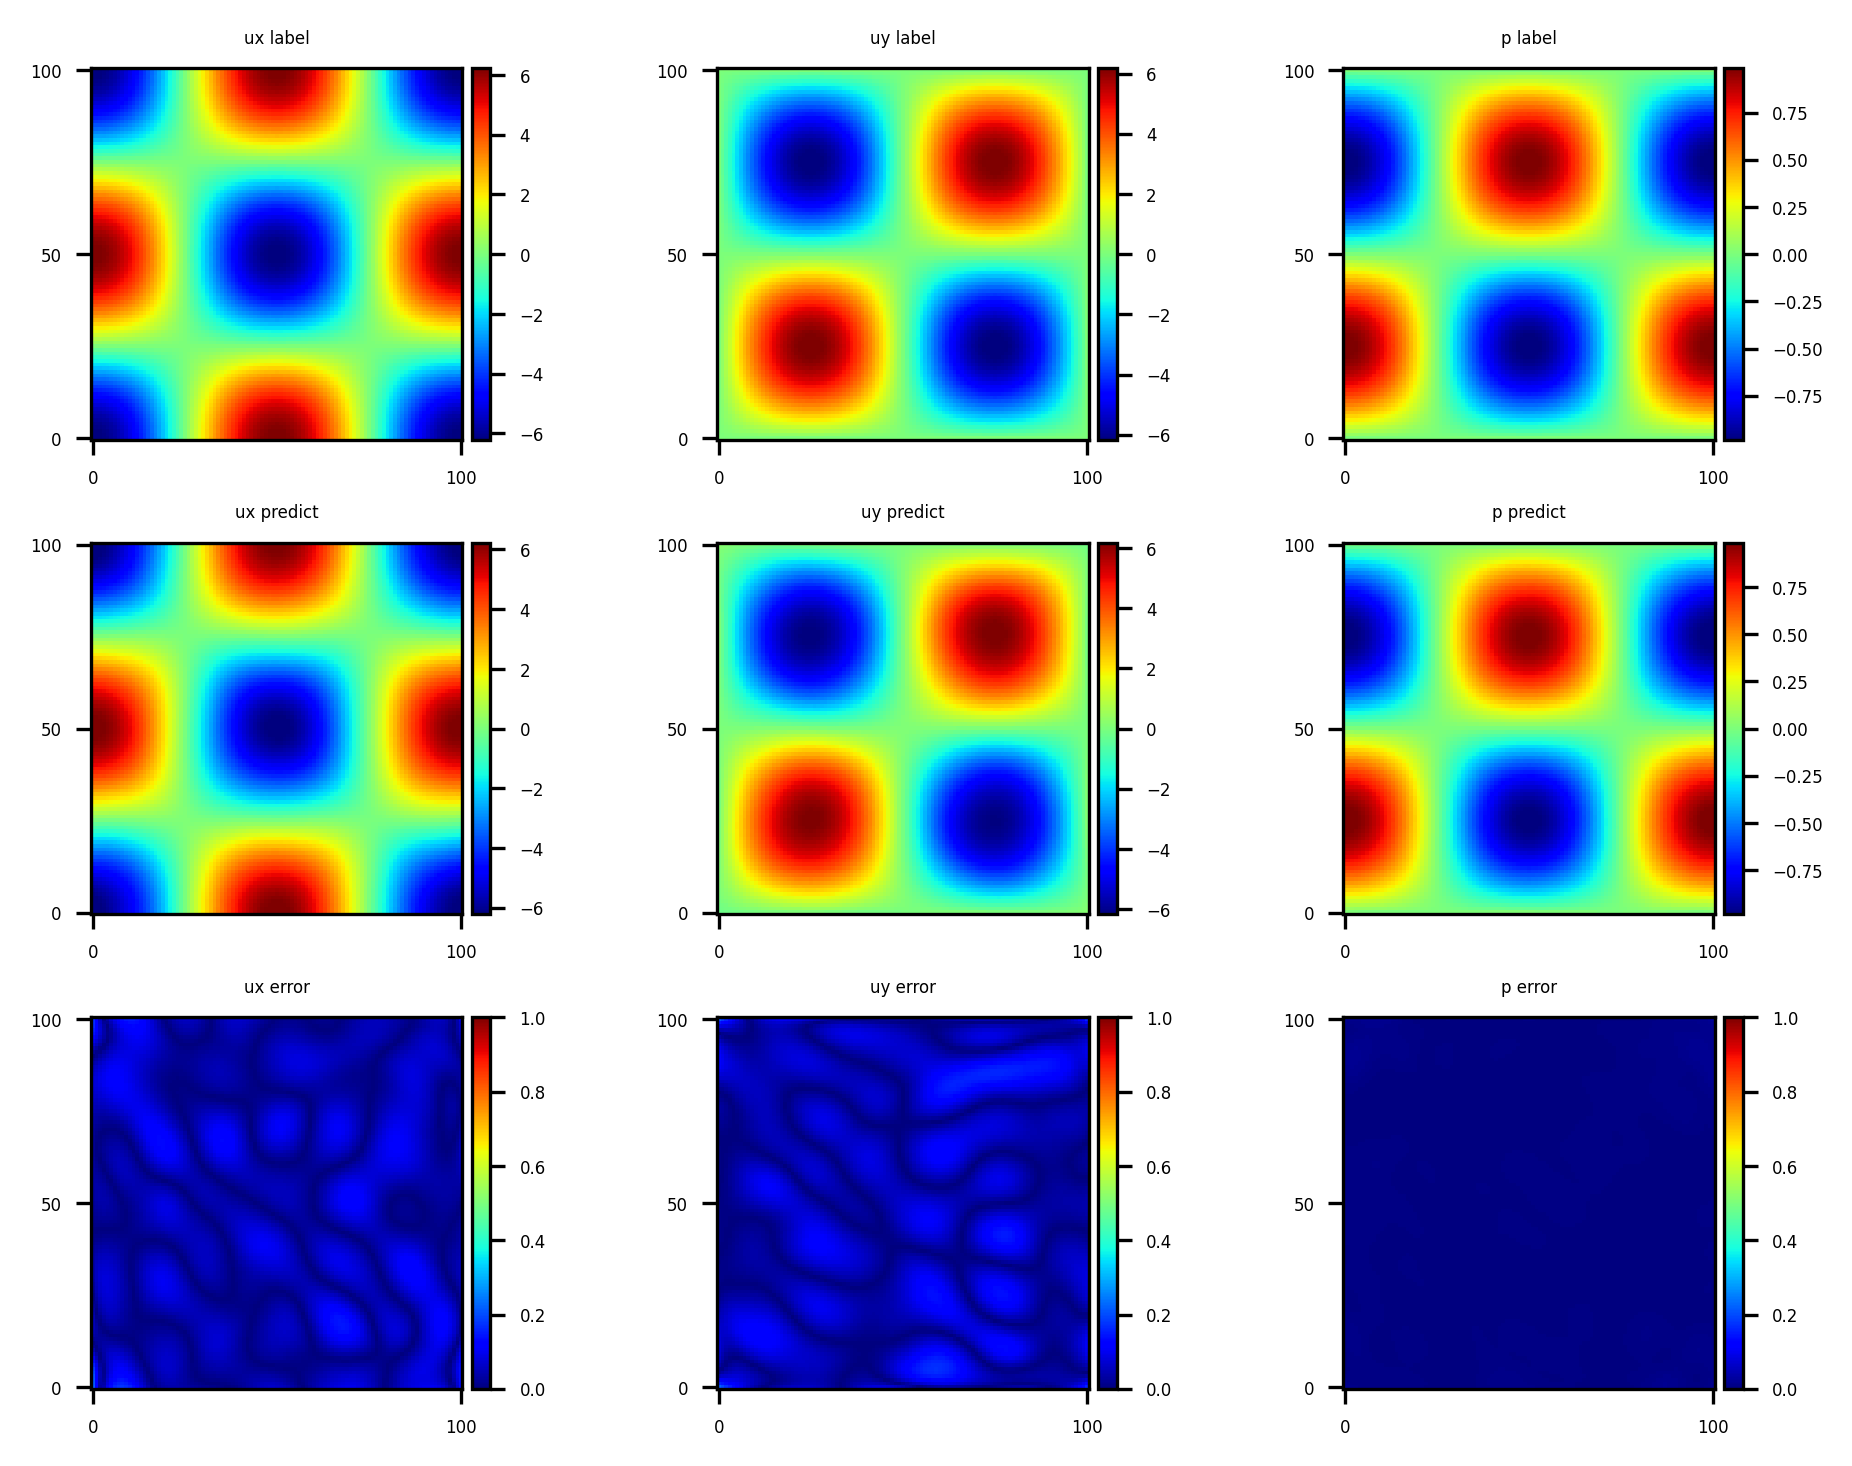

In [2]:
from src import visual
visual(model, config)